<img height="100" src="https://i.postimg.cc/gjptBxF4/logo-gas-removebg-preview.png" width="250"/>

# Pré-processamento dos dados

In [61]:
import os
from warnings import filterwarnings

import pandas as pd

filterwarnings("ignore")
path = os.path.join(os.getcwd(), 'data', "data_article.xlsx")
df = pd.read_excel(path,"Dados_finais")
df.rename(columns=dict(Fotop="N"),inplace=True)

# Dropping colinear features
df.drop(columns=["Dia","Rep",'DC','DG','NDJ',
                 'PS','NAC','Qg','DR','URMIN','URMAX','UR2M',"P-ETP","Qo",
                 "ALT","Rajada Máxima","EXC","TMAX","TMIN","ETR","ETp","T2M","DEF","N"
                 ], inplace=True)

In [62]:
# Selecionar a primeira ocorrência de cada estádio fenológico
df = df.drop_duplicates(subset=['Cultivar','Estadio'], keep='first')

In [63]:
from scipy.stats import zscore

# Standardizing data (z-score)
df_pad = zscore(df.drop(columns=['Cultivar', 'Estadio']))

# Preparing data for VIF

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

features = df.iloc[:,2:].round(2)

# Add constant
X = add_constant(features)

# Calculating VIF
df_VIF = pd.DataFrame()
df_VIF['feature'] = X.columns
df_VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
df_VIF.round(2)

,feature,VIF
0,const,112.21
1,NDH > 90%,1.92
2,PREC,1.42
3,W2M,1.54
4,PAR,1.60
5,ARM,2.75
6,SDG,1.97


# Spearman correlation

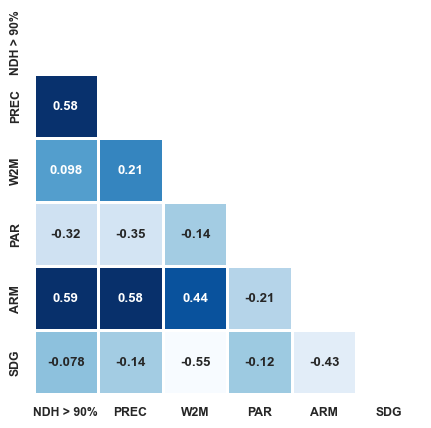

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convertendo dados padronizados para DataFrame
dados_pad_df = pd.DataFrame(df_pad, columns=df.columns[2:], index=df.index)

# Calculando a matriz de correlação de Spearman
corr_matrix = dados_pad_df.corr(method='spearman')

# Criando uma máscara para a diagonal superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurando o tamanho e a resolução da figura
plt.figure(figsize=(5, 5))

# Plotando o heatmap com a máscara
sns.set_theme(style='white', context="paper")
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="Blues", linewidths=.9, cbar=False)
plt.grid(False)

# Exibindo o gráfico
plt.show()

| Climatic parameter | Description                            | Numerical quantity |
|--------------------|----------------------------------------|--------------------|
| NDH>90%            | Hours with relative humidity above 90% | hours              |
| PREC               | Precipitation                          | mm                 |
| W2M                | Wind speed at 2 m                      | m s⁻¹              |
| PAR                | Photosynthetically active radiation    | MJ m⁻² d⁻¹         |
| ARM                | Water soil storage                     | mm                 |
| SDG                | Sum of degree-days                     | °C d⁻¹             |


In [66]:
# Cluster 1:  Cultivar C10, C14, C15, C16, C17, C18, C19, C20, C9 (Early)
df1 = df.loc[df['Cultivar'].isin(["C10", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C9"])].reset_index(
    drop=True)
df1_pad = zscore(df1.drop(columns=['Cultivar', 'Estadio']))

# Cluster 2:  Cultivar C1, C11, C7 (Late)
df2 = df.loc[df['Cultivar'].isin(["C1", "C11", "C7"])].reset_index(drop=True)
df2_pad = zscore(df2.drop(columns=['Cultivar', 'Estadio']))

# Cluster 3:  Cultivar C12, C13, C2, C21, C22, C3, C4, C5, C6, C8 (Standard)
df3 = df.loc[df['Cultivar'].isin(["C12", "C13", "C2", "C21", "C22", "C3", "C4", "C5", "C6", "C8"])].reset_index(
    drop=True)
df3_pad = zscore(df3.drop(columns=['Cultivar', 'Estadio']))

# Cluster 1

In [67]:
from pca import pca

# Converter dados padronizados para DataFrame mantendo os nomes das colunas 
dados_pad_df = pd.DataFrame(df1_pad, columns=df1.drop(columns=['Cultivar',"Estadio"]).columns)

# Criar e ajustar o modelo PCA
modelo = pca(n_components=2,
             alpha=0.05,
             random_state=42,
             verbose=4)

resultado = modelo.fit_transform(dados_pad_df)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >DEBUG> Set verbose to 10
[scatterd] >DEBUG> Colors are all set to [0, 0.1, 0.4].
[scatterd] >DEBUG> Colors are based on the input [labels] and on [cmap].
[scatterd] >INFO> Add density layer


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


<Figure size 500x500 with 0 Axes>

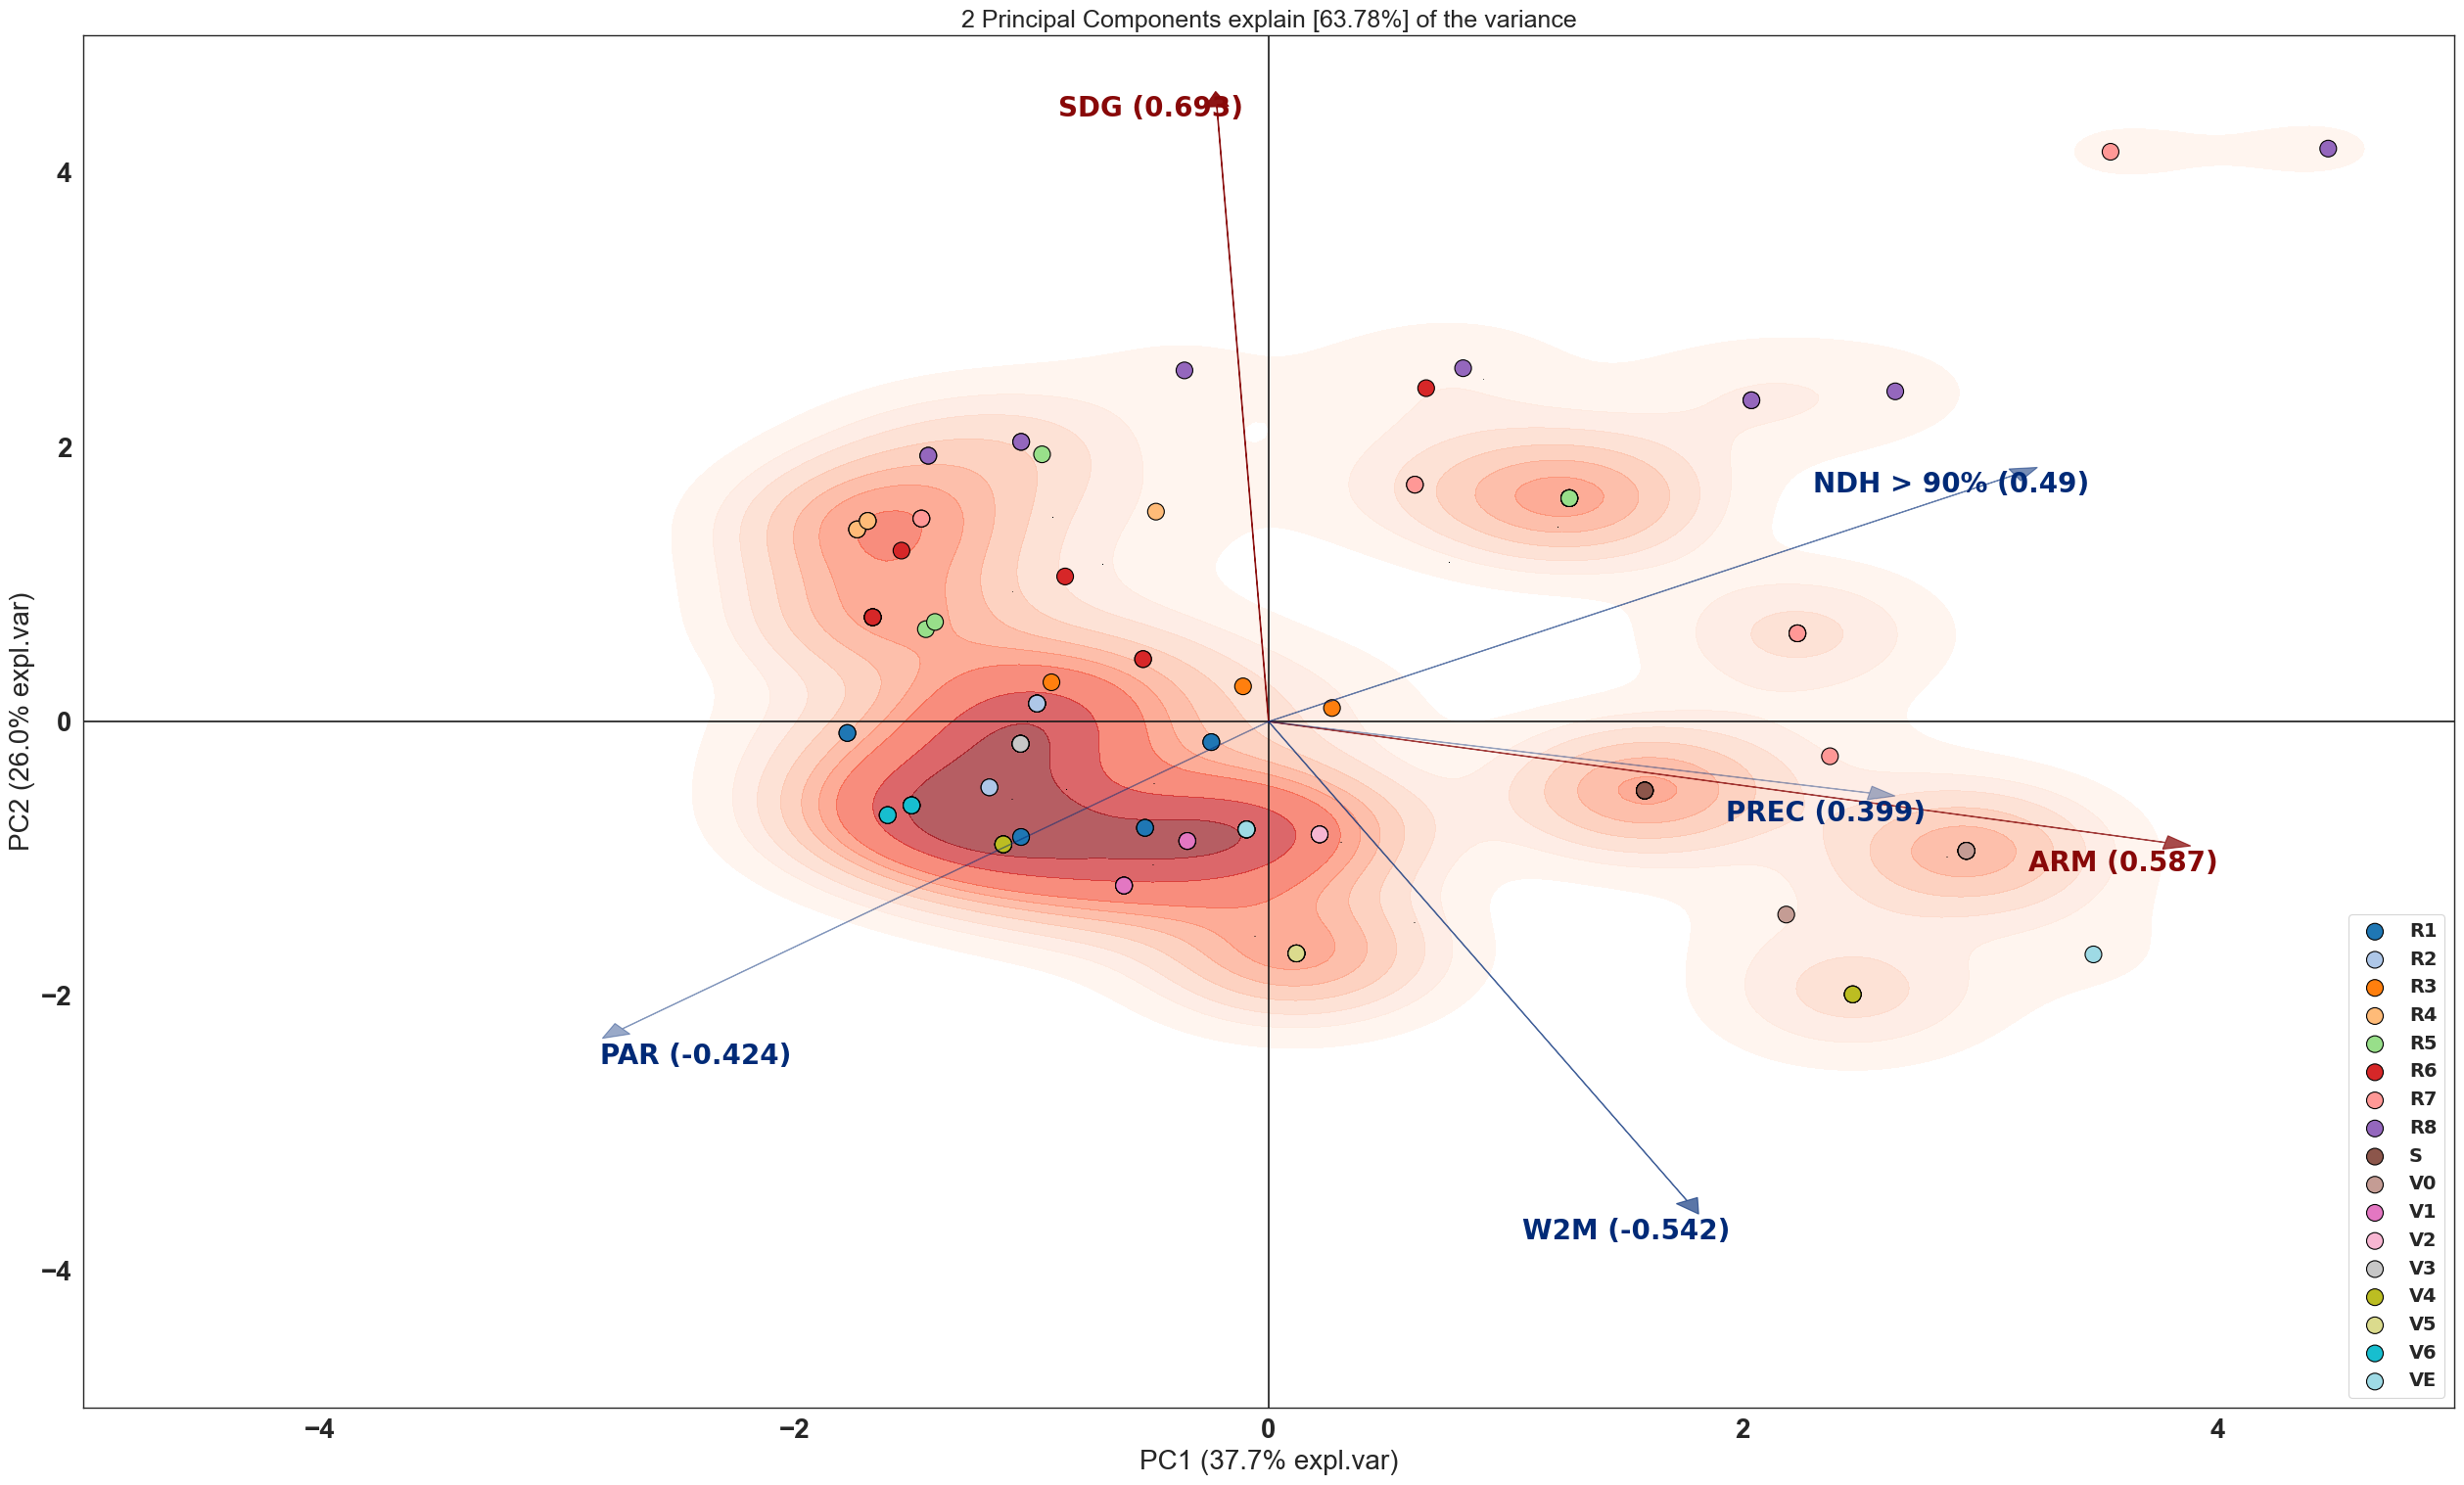

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir as configurações da figura para evitar tamanhos excessivos
sns.set_theme(style="white", context="paper")
plt.figure(figsize=(5, 5))  # Ajuste o tamanho conforme necessário

# Remova o parâmetro variable_names que está causando o erro
modelo.biplot(cmap="tab20", legend=4, density=True,
              SPE=False, marker='o', visible=True,
              jitter=0, fontweight="bold",
              arrowdict={'fontsize': 20}, fontsize=0,
              labels=df1['Estadio'].values, alpha=1)

# Adicionar linhas centrais
plt.plot([0, 0], [-10, 10], "k-")
plt.plot([-10, 10], [0, 0], "k-")

# Definir os limites do gráfico
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.tight_layout()

##plt.title("")
plt.grid(False)
fig_path = os.path.join(os.getcwd(), 'images', "Figure 3.jpg")
plt.savefig(fig_path, dpi=600)

# Mostrar o gráfico
plt.show()

In [69]:
print("Variância explicada por cada componente:")
print(f"{resultado['explained_var'][1]*100:.2f}% Precoce")
resultado['topfeat'].round(3)

Variância explicada por cada componente:
63.79% Precoce


,PC,feature,loading,type
0,PC1,ARM,0.587,best
1,PC2,SDG,0.693,best
2,PC1,NDH > 90%,0.490,weak
3,PC1,PREC,0.399,weak
4,PC2,W2M,-0.542,weak
5,PC1,PAR,-0.424,weak


In [70]:
# Converter dados padronizados para DataFrame mantendo os nomes das colunas
dados_pad_df = pd.DataFrame(df2_pad, columns=df2.drop(columns=['Cultivar',"Estadio"]).columns)

# Criar e ajustar o modelo PCA
modelo = pca(n_components=2,
             alpha=0.05,
             random_state=42,
             verbose=4)

resultado = modelo.fit_transform(dados_pad_df)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[pca] >Plot PC1 vs PC2 with loadings.

[scatterd] >DEBUG> Set verbose to 10
[scatterd] >DEBUG> Colors are all set to [0, 0.1, 0.4].
[scatterd] >DEBUG> Colors are based on the input [labels] and on [cmap].
[scatterd] >INFO> Add density layer
[scatterd] >INFO> Create scatterplot



[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


<Figure size 500x500 with 0 Axes>

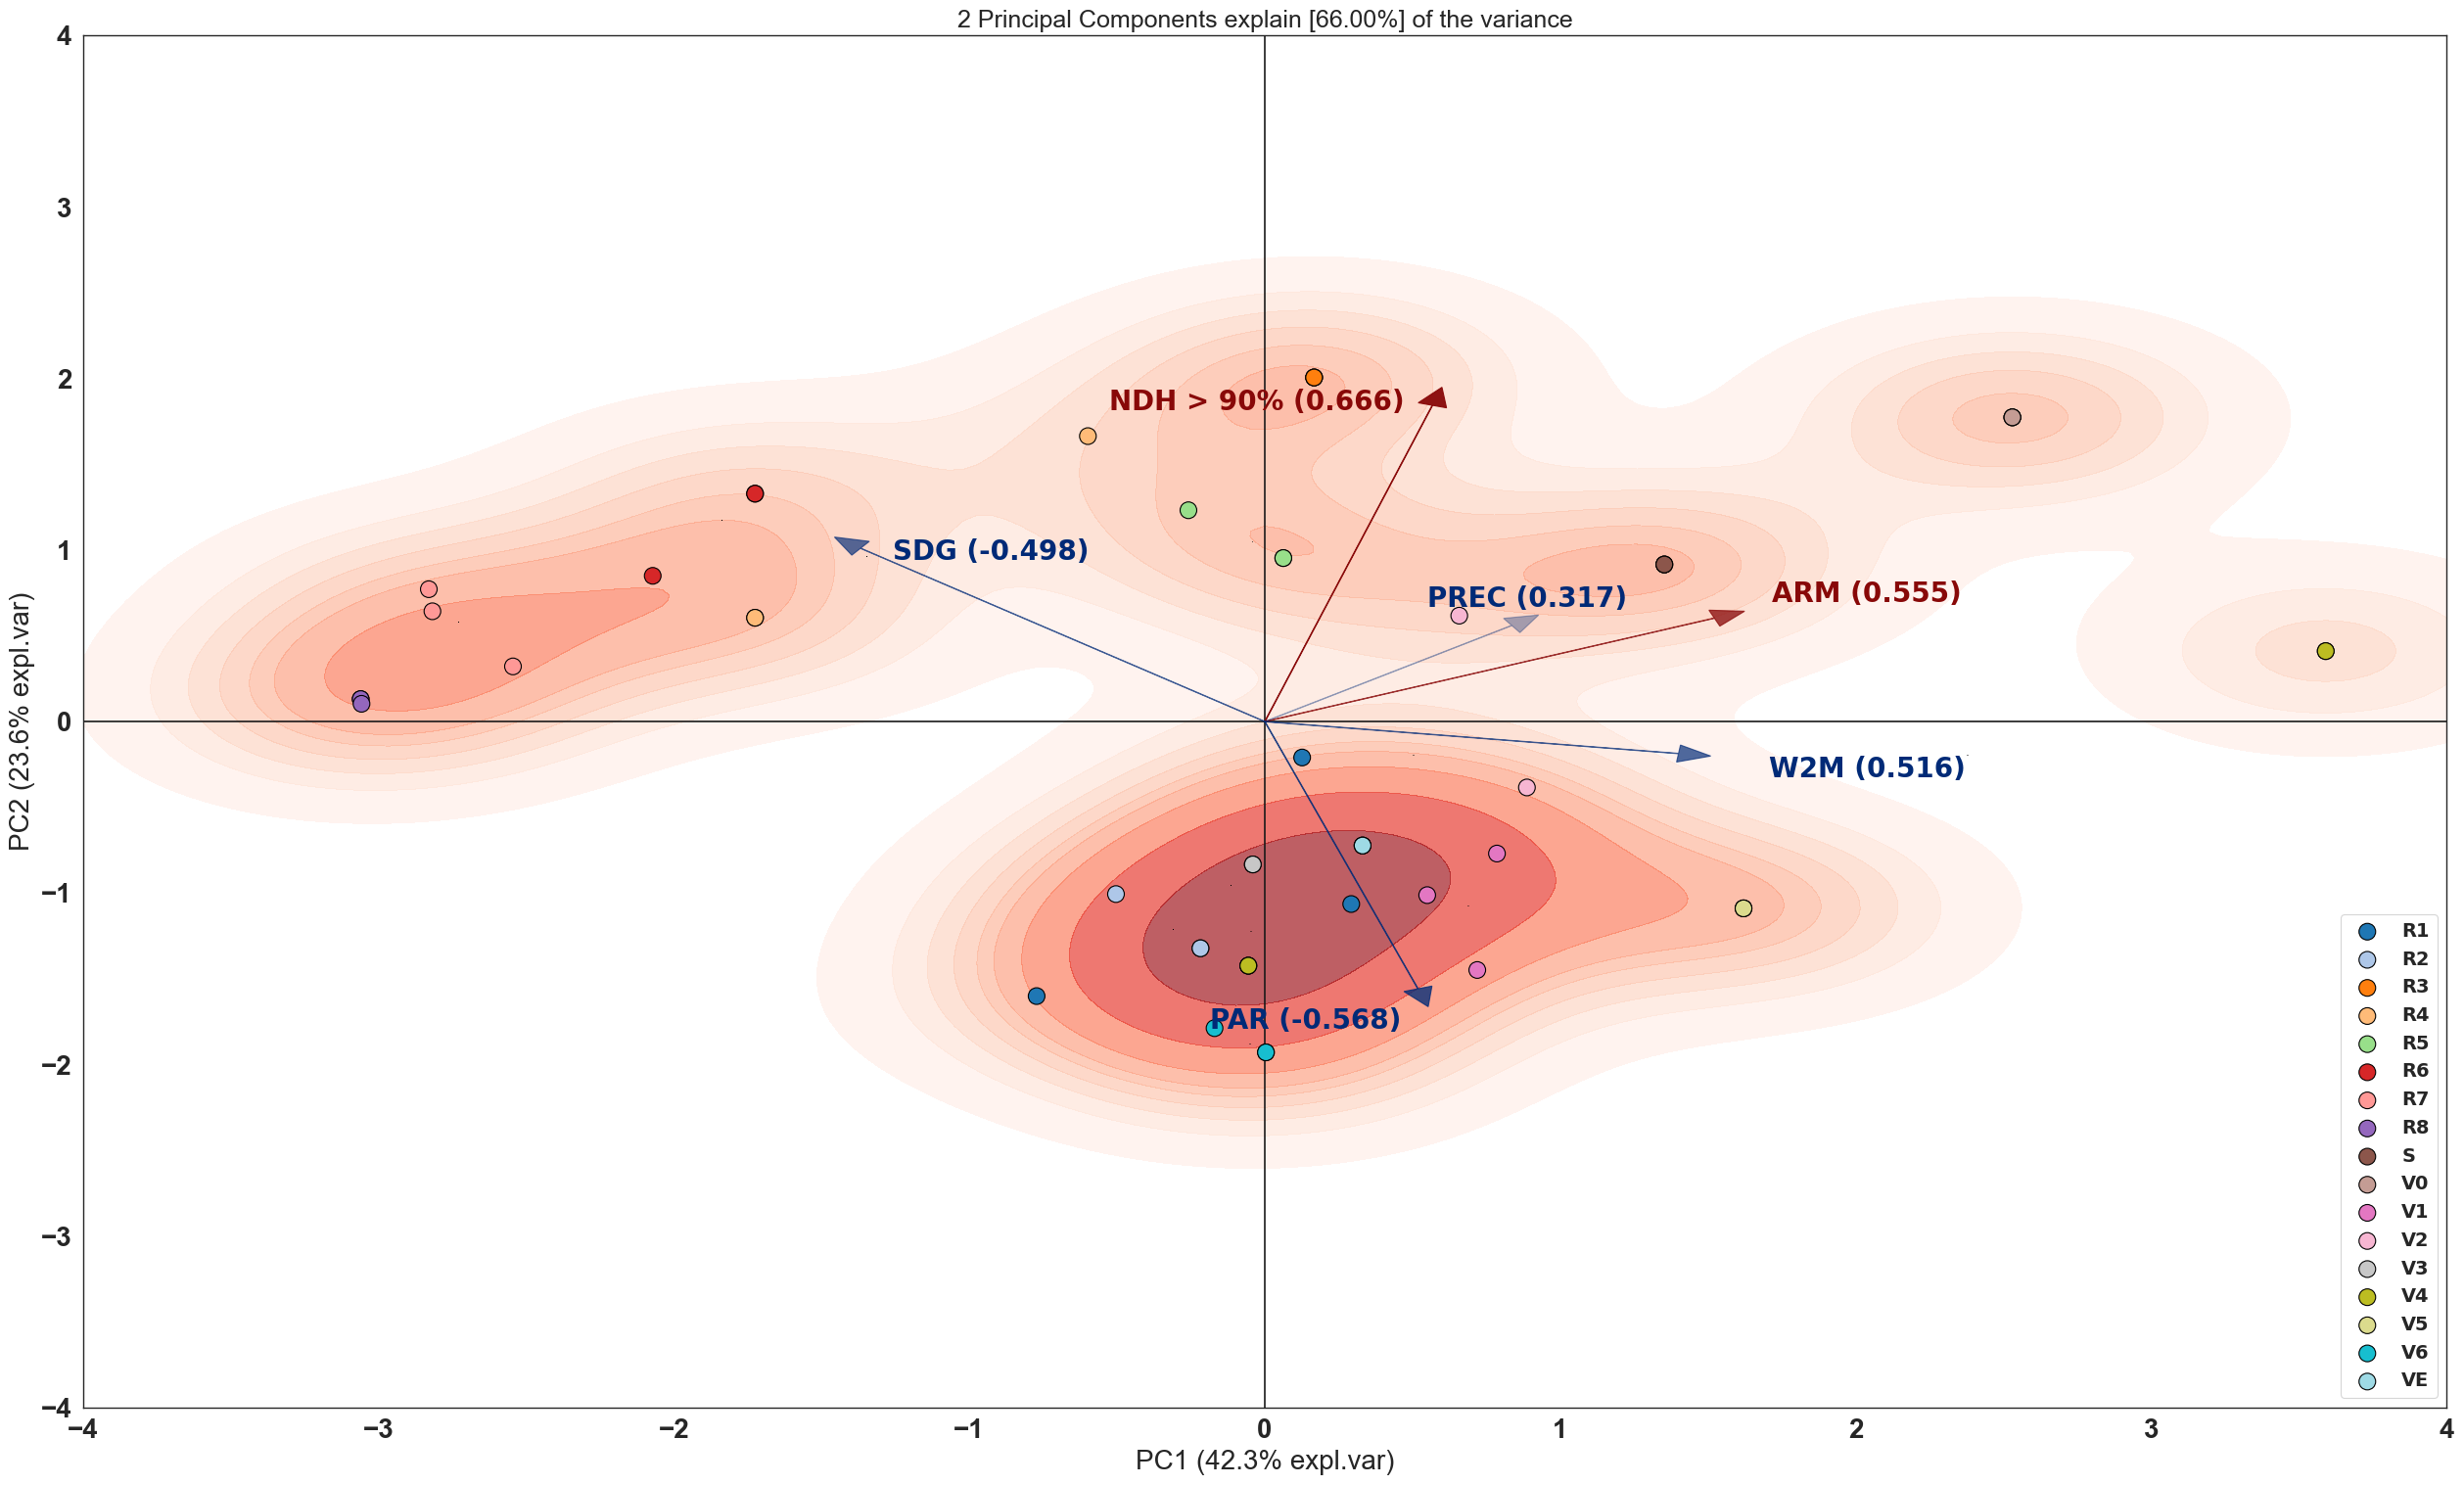

In [71]:
# Definir as configurações da figura para evitar tamanhos excessivos
sns.set_theme(style="white", context="paper")
plt.figure(figsize=(5, 5))  # Ajuste o tamanho conforme necessário

# Remova o parâmetro variable_names que está causando o erro
modelo.biplot(cmap="tab20", legend=4, density=True, SPE=False, marker='o', visible=True, jitter=0, fontweight="bold",
              arrowdict={'fontsize': 20}, fontsize=0, labels=df2['Estadio'].values, alpha=1)

# Adicionar linhas centrais
plt.plot([0, 0], [-10, 10], "k-")
plt.plot([-10, 10], [0, 0], "k-")

# Definir os limites do gráfico
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.tight_layout()

##plt.title("")
plt.grid(False)
fig_path = os.path.join(os.getcwd(), 'images', "Figure 5.jpg")
plt.savefig(fig_path, dpi=600)

# Mostrar o gráfico
plt.show();

In [72]:
print("Variância explicada por cada componente:")
print(f"{resultado['explained_var'][1]*100:.2f}% Tardio")
resultado['topfeat'].round(3)

Variância explicada por cada componente:
66.01% Tardio


,PC,feature,loading,type
0,PC1,ARM,0.555,best
1,PC2,NDH > 90%,0.666,best
2,PC1,PREC,0.317,weak
3,PC1,W2M,0.516,weak
4,PC2,PAR,-0.568,weak
5,PC1,SDG,-0.498,weak


# Cluster 3

In [73]:
# Converter dados padronizados para DataFrame mantendo os nomes das colunas
dados_pad_df = pd.DataFrame(df3_pad, columns=df3.drop(columns=['Cultivar',"Estadio"]).columns)

# Criar e ajustar o modelo PCA
modelo = pca(n_components=2,
             alpha=0.05,
             random_state=42,
             verbose=4)

resultado = modelo.fit_transform(dados_pad_df)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >DEBUG> Set verbose to 10
[scatterd] >DEBUG> Colors are all set to [0, 0.1, 0.4].
[scatterd] >DEBUG> Colors are based on the input [labels] and on [cmap].
[scatterd] >INFO> Add density layer


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


<Figure size 500x500 with 0 Axes>

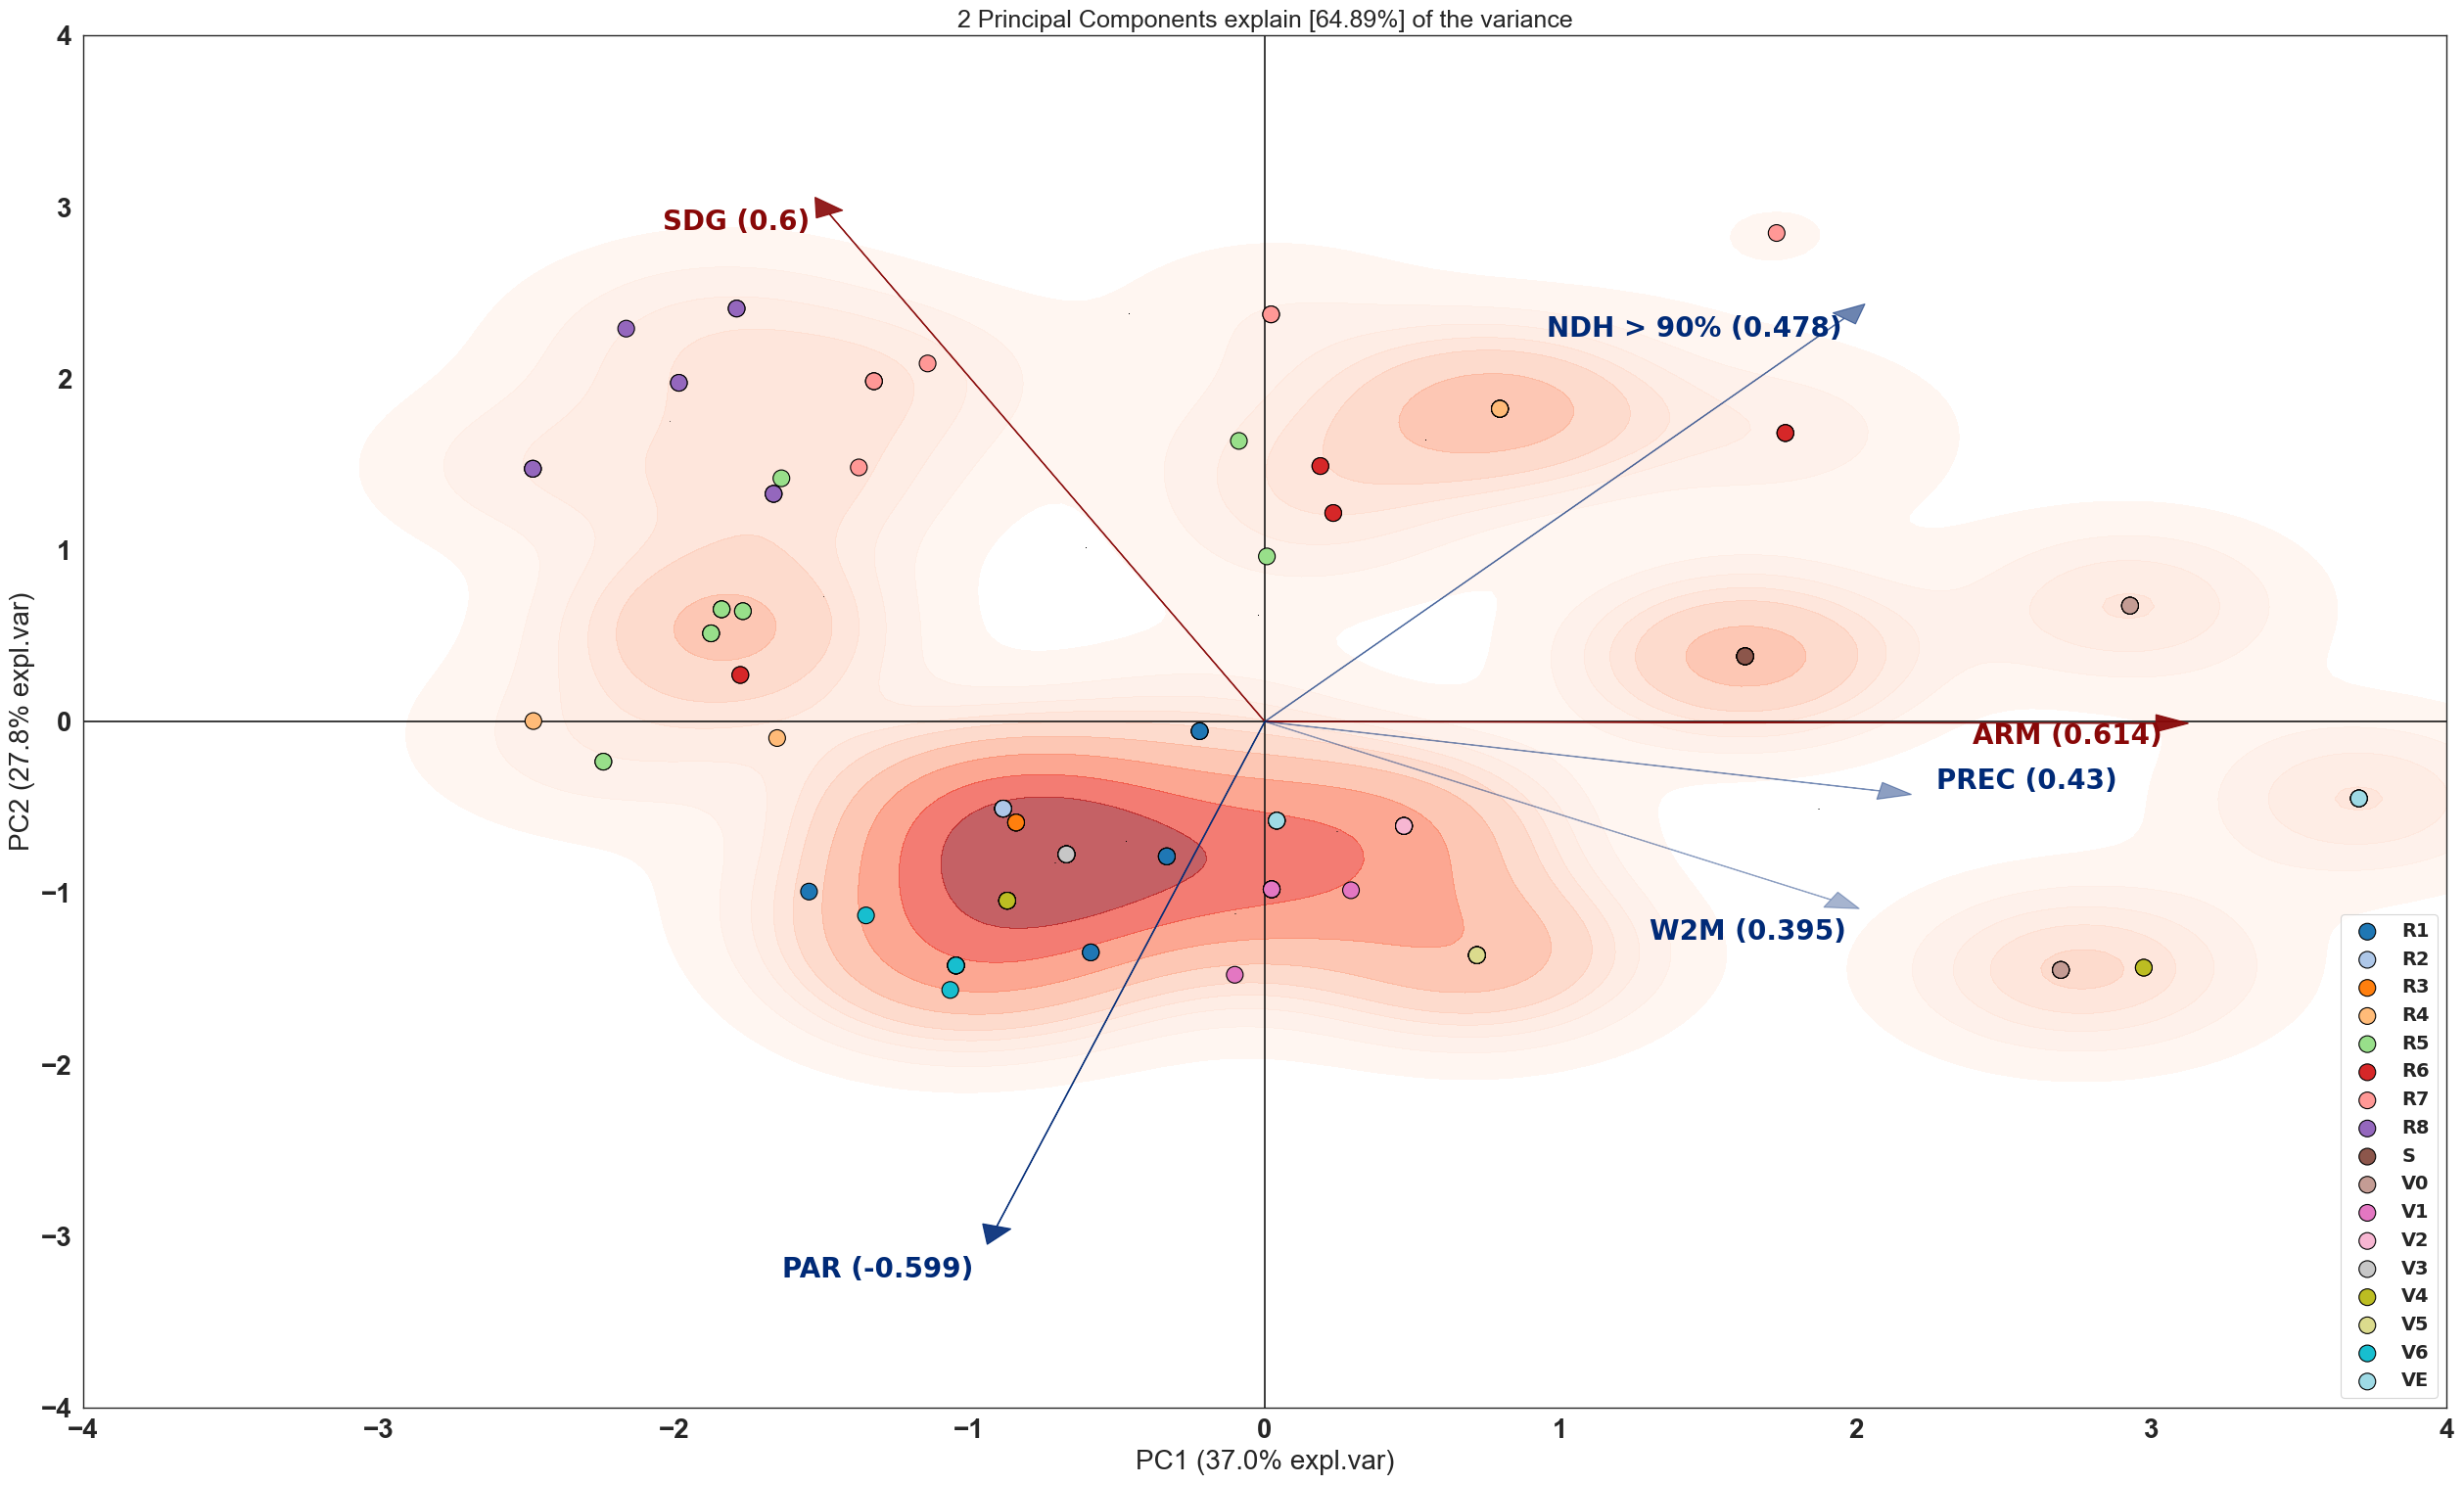

In [74]:
# Definir as configurações da figura para evitar tamanhos excessivos
sns.set_theme(style="white", context="paper")
plt.figure(figsize=(5, 5))  # Ajuste o tamanho conforme necessário

# Remova o parâmetro variable_names que está causando o erro
modelo.biplot(cmap="tab20", legend=4, density=True, SPE=False, marker='o',
              visible=True, jitter=0, fontweight="bold",
              arrowdict={'fontsize': 20}, fontsize=0, labels=df3['Estadio'].values,
              alpha=1)

# Adicionar linhas centrais
plt.plot([0, 0], [-10, 10], "k-")
plt.plot([-10, 10], [0, 0], "k-")

# Definir os limites do gráfico
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.tight_layout()

##plt.title("")
plt.grid(False)
fig_path = os.path.join(os.getcwd(), 'images', "Figure 4.jpg")
plt.savefig(fig_path, dpi=600)

# Mostrar o gráfico
plt.show();

In [75]:
# Visualizar a variância explicada
print("Variância explicada por cada componente:")
print(f"{resultado['explained_var'][1]*100:.2f}% Normal")
resultado['topfeat'].round(3)

Variância explicada por cada componente:
64.89% Normal


,PC,feature,loading,type
0,PC1,ARM,0.614,best
1,PC2,SDG,0.600,best
2,PC2,NDH > 90%,0.478,weak
3,PC1,PREC,0.430,weak
4,PC1,W2M,0.395,weak
5,PC2,PAR,-0.599,weak


In [76]:
# Dicionário para armazenar os resultados por tipo de cultivar
cultivar_results = {}

# CLUSTER 1 - PRECOCE
# Converter dados padronizados para DataFrame mantendo os nomes das colunas
dados_pad_df1 = pd.DataFrame(df1_pad, columns=df1.drop(columns=['Cultivar',"Estadio"]).columns)
modelo1 = pca(n_components=2, alpha=0.05, random_state=42, verbose=0)
resultado1 = modelo1.fit_transform(dados_pad_df1)

# Extrair autovetores (eigenvectors/loadings)
loadings1 = resultado1['loadings']
# Extrair scores
scores1 = resultado1['PC']
# Combinar com rótulos de estágio
scores_with_labels1 = pd.DataFrame(scores1)
scores_with_labels1['Estadio'] = df1['Estadio'].values
scores_with_labels1['Tipo'] = 'Early'

# CLUSTER 2 - TARDIO
dados_pad_df2 = pd.DataFrame(df2_pad, columns=df2.drop(columns=['Cultivar',"Estadio"]).columns)
modelo2 = pca(n_components=2, alpha=0.05, random_state=42, verbose=0)
resultado2 = modelo2.fit_transform(dados_pad_df2)

# Extrair autovetores e scores
loadings2 = resultado2['loadings']
scores2 = resultado2['PC']
scores_with_labels2 = pd.DataFrame(scores2)
scores_with_labels2['Estadio'] = df2['Estadio'].values
scores_with_labels2['Tipo'] = 'Late'

# CLUSTER 3 - NORMAL
dados_pad_df3 = pd.DataFrame(df3_pad, columns=df3.drop(columns=['Cultivar',"Estadio"]).columns)
modelo3 = pca(n_components=2, alpha=0.05, random_state=42, verbose=0)
resultado3 = modelo3.fit_transform(dados_pad_df3)

# Extrair autovetores e scores
loadings3 = resultado3['loadings']
scores3 = resultado3['PC']
scores_with_labels3 = pd.DataFrame(scores3)
scores_with_labels3['Estadio'] = df3['Estadio'].values
scores_with_labels3['Tipo'] = 'Standard'

# Combinar todos os scores em um único dataframe
all_scores = pd.concat([scores_with_labels1, scores_with_labels2, scores_with_labels3])

# Renomear as colunas para melhor clareza
all_scores.rename(columns={0: 'PC1', 1: 'PC2'}, inplace=True)

# Mostrar o dataframe com os scores
# print("Scores por estágio e tipo de cultivar:")
# print(all_scores)

# Criar um dataframe com loadings (eigenvectors) para cada tipo de cultivar
loadings_precoce = pd.DataFrame(loadings1.T, index=dados_pad_df1.columns, columns=['PC1','PC2'])
loadings_precoce['Tipo'] = 'Early'

loadings_tardio = pd.DataFrame(loadings2.T, index=dados_pad_df2.columns, columns=['PC1','PC2'])
loadings_tardio['Tipo'] = 'Late'

loadings_normal = pd.DataFrame(loadings3.T, index=dados_pad_df3.columns, columns=['PC1','PC2'])
loadings_normal['Tipo'] = 'Standard'

# Combinar todos os loadings
all_loadings = pd.concat([loadings_precoce, loadings_tardio, loadings_normal])

# Resetar o índice para ter a variável como coluna
all_loadings = all_loadings.reset_index()
all_loadings.rename(columns={'index': 'Variável'}, inplace=True)

# Mostrar o dataframe com os loadings
print("\nLoadings (eigenvectors) por variável e tipo de cultivar:")
all_loadings.round(3)


Loadings (eigenvectors) por variável e tipo de cultivar:


,Variável,PC1,PC2,Tipo
0,NDH > 90%,0.490,0.280,Early
1,PREC,0.399,-0.082,Early
2,W2M,0.274,-0.542,Early
3,PAR,-0.424,-0.349,Early
4,ARM,0.587,-0.137,Early
5,SDG,-0.034,0.693,Early
6,NDH > 90%,0.205,0.666,Late
7,PREC,0.317,0.212,Late
8,W2M,0.516,-0.069,Late
9,PAR,0.189,-0.568,Late


# Cosine Similarity

$\cos(\theta) = \frac{\mathbf{score}_{\text{estadio}} \cdot \mathbf{loading}}{||\mathbf{score}_{\text{estadio}}|| \times ||\mathbf{loading}||}$

<br> Korenius, T., Laurikkala, J., & Juhola, M. (2007). On principal component analysis, cosine and Euclidean measures in information retrieval. Information Sciences, 177(22), 4893–4905. https://doi.org/10.1016/j.ins.2007.05.027

In [77]:
# Analisar quais variáveis mais influenciam cada estágio de desenvolvimento

# Para cada tipo de cultivar, identificar as variáveis mais importantes por estágio
estadios_unicos = all_scores['Estadio'].unique()
tipos_cultivares = ['Early', 'Late', 'Standard']

# Criar DataFrame para armazenar a influência de cada variável em cada estágio
influencia_matrix = pd.DataFrame(index=estadios_unicos)

# Para cada tipo de cultivar
for tipo in tipos_cultivares:
    # Filtrar scores para este tipo
    scores_tipo = all_scores[all_scores['Tipo'] == tipo]

    # Filtrar loadings para este tipo
    loadings_tipo = all_loadings[all_loadings['Tipo'] == tipo]

    # Para cada estágio neste tipo
    for estadio in scores_tipo['Estadio'].unique():
        # Obter o score médio deste estágio
        score_estadio = scores_tipo[scores_tipo['Estadio'] == estadio][['PC1', 'PC2']].values[0]

        # Calcular a contribuição ponderada de cada variável neste estágio
        for _, row in loadings_tipo.iterrows():
            var_name = row['Variável']
            loading = np.array([row['PC1'], row['PC2']])

            # Calcular a contribuição como produto escalar normalizado (Adimensional '-1' até '1')
            contribution = np.dot(score_estadio, loading) / np.linalg.norm(score_estadio) / np.linalg.norm(loading)

            # Adicionar ao dataframe de influência
            col_name = f"{var_name}: {tipo}"
            if col_name not in influencia_matrix.columns:
                influencia_matrix[col_name] = np.nan

            influencia_matrix.loc[estadio, col_name] = contribution

# Preencher valores nulos com zeros
influencia_matrix = influencia_matrix.fillna(0)

# Ordenar o dataframe para melhor visualização
influencia_matrix = influencia_matrix.reindex(sorted(influencia_matrix.columns), axis=1)

# Mostrar a matriz de influência
print("\nMatriz de influência das variáveis por estágio e tipo de cultivar:")
influencia_matrix.round(2)


Matriz de influência das variáveis por estágio e tipo de cultivar:


,ARM: Early,ARM: Late,ARM: Standard,NDH > 90%: Early,NDH > 90%: Late,NDH > 90%: Standard,PAR: Early,PAR: Late,PAR: Standard,PREC: Early,PREC: Late,PREC: Standard,SDG: Early,SDG: Late,SDG: Standard,W2M: Early,W2M: Late,W2M: Standard
S,1.00,0.98,0.97,0.68,0.78,0.80,-0.54,-0.27,-0.50,0.99,1.00,0.91,-0.35,-0.33,-0.23,0.70,0.75,0.75
VE,0.11,0.05,0.99,-0.60,-0.75,0.54,0.72,0.99,-0.18,0.08,-0.16,1.00,-0.99,-0.87,-0.55,0.83,0.53,0.93
V0,1.00,0.97,0.88,0.68,0.79,0.20,-0.54,-0.29,0.19,0.99,1.00,0.95,-0.35,-0.32,-0.82,0.70,0.74,1.00
V1,-0.24,0.41,0.29,-0.84,-0.46,-0.55,0.92,0.89,0.83,-0.27,0.20,0.46,-0.87,-0.99,-0.98,0.59,0.80,0.71
V2,-0.93,0.93,-0.65,-0.93,0.87,-1.00,0.86,-0.42,0.91,-0.94,0.99,-0.50,-0.10,-0.18,-0.38,-0.31,0.63,-0.22
V3,-0.62,-0.40,-0.64,-0.99,-0.97,-1.00,1.00,0.94,0.92,-0.64,-0.59,-0.48,-0.59,-0.56,-0.40,0.21,0.09,-0.20
V4,0.29,0.97,0.90,-0.43,0.40,0.24,0.58,0.21,0.15,0.27,0.89,0.97,-1.00,-0.73,-0.79,0.92,0.97,1.00
V5,-0.82,0.57,0.47,-0.99,-0.29,-0.38,0.95,0.79,0.71,-0.83,0.38,0.63,-0.33,-1.00,-1.00,-0.08,0.90,0.83
V6,-0.81,-0.37,-0.56,-0.99,-0.96,-1.00,0.96,0.95,0.96,-0.82,-0.56,-0.39,-0.35,-0.60,-0.49,-0.07,0.13,-0.10
R1,-0.36,-0.11,-0.39,-0.90,-0.84,-0.96,0.96,1.00,0.99,-0.38,-0.32,-0.21,-0.80,-0.79,-0.65,0.49,0.39,0.10


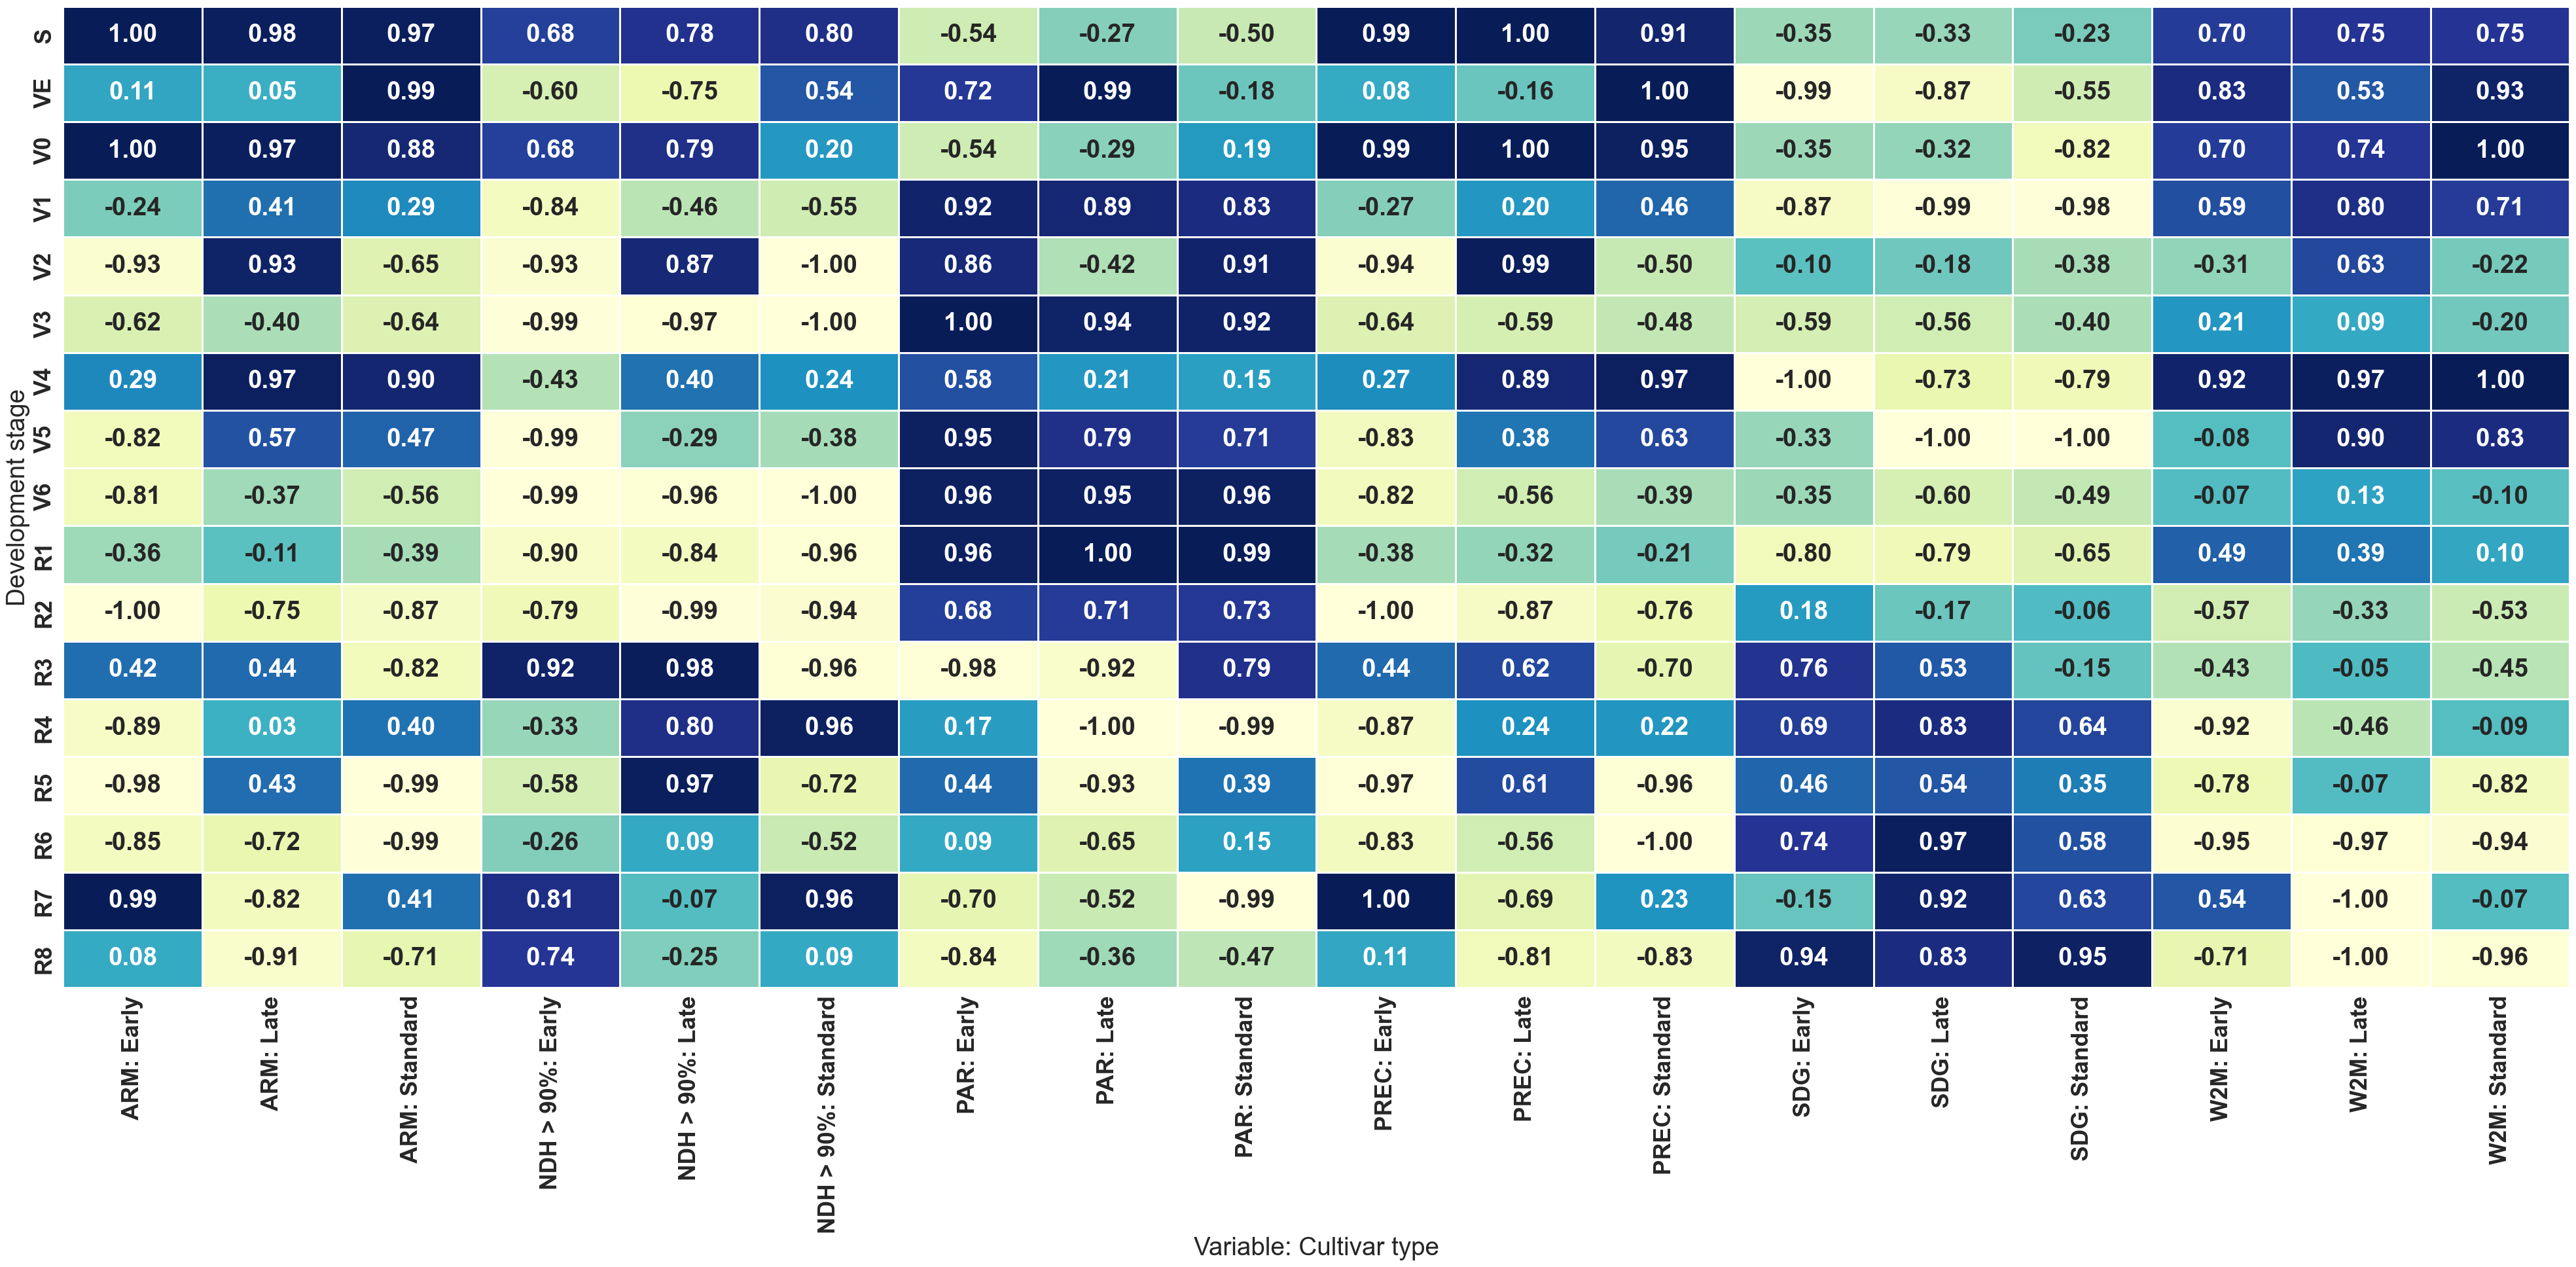

In [78]:
# Criar um mapa de calor para visualizar a influência
sns.set_theme(style="white", context="paper", font_scale=2.9)
plt.figure(figsize=(40, 20))
sns.heatmap(influencia_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=1, cbar=False)
#plt.title("Influência dos Eigenvectors nos Estágios de Desenvolvimento por Tipo de Cultivar")
plt.ylabel("Development stage")
plt.xlabel("Variable: Cultivar type")
plt.xticks(rotation=90)
plt.tight_layout()

# Saving figure (Supplementary image)
fig_path = os.path.join(os.getcwd(), 'images', "S1.jpg")
##plt.savefig(fig_path, dpi=600)

plt.show()

# Filtrando por importancia de PCA

In [79]:
types = ['Early', 'Late', 'Standard']
variables = ['SDG', 'ARM', 'NDH > 90%']
colunas_desejadas = [f"{v}: {t}" for v in variables for t in types]
influencia_matrix_filter = influencia_matrix[colunas_desejadas]

# Saving dataframe
path_results = os.path.join(os.getcwd(), "results", "influencia_matrix_filter.xlsx")
influencia_matrix_filter.to_excel(path_results)

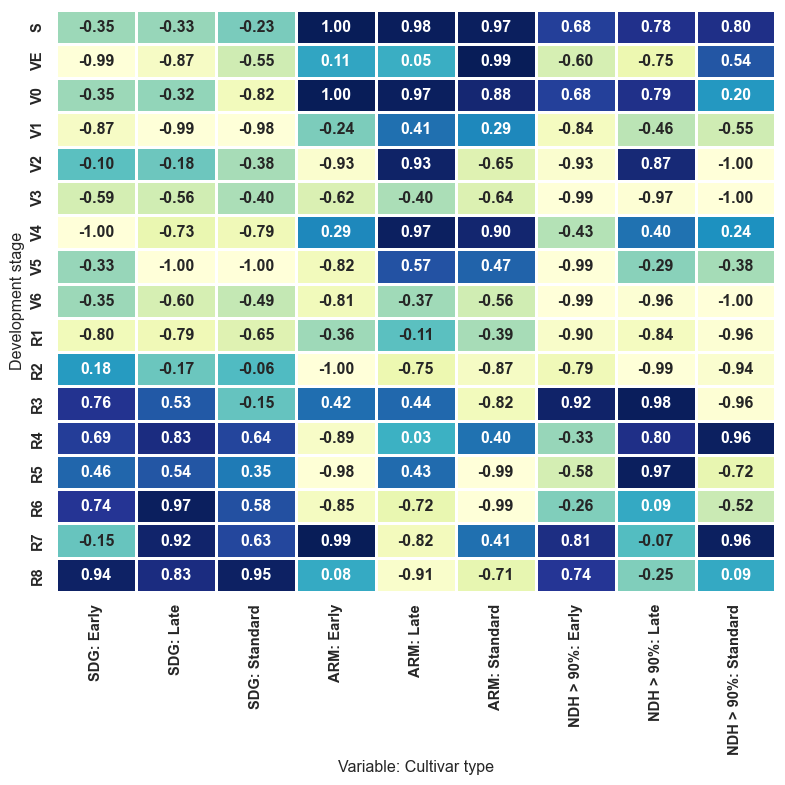

In [80]:
# Criar um mapa de calor para visualizar a influência
sns.set_theme(style="white", context="paper", font_scale=1.2)
plt.figure(figsize=(8,8))
sns.heatmap(influencia_matrix_filter, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=1, cbar=False)
#plt.title("Influência dos Eigenvectors nos Estágios de Desenvolvimento por Tipo de Cultivar")
plt.ylabel("Development stage")
plt.xlabel("Variable: Cultivar type")
plt.xticks(rotation=90)
plt.tight_layout()

# Saving figure
fig_path = os.path.join(os.getcwd(), 'images', "Figure 6.jpg")
plt.savefig(fig_path, dpi=600)

plt.show()

In [81]:
influencia_matrix_filter

,SDG: Early,SDG: Late,SDG: Standard,ARM: Early,ARM: Late,ARM: Standard,NDH > 90%: Early,NDH > 90%: Late,NDH > 90%: Standard
S,-0.348099,-0.332806,-0.229953,0.996966,0.976309,0.972930,0.677838,0.779443,0.798751
VE,-0.986108,-0.874992,-0.550031,0.110522,0.051983,0.993144,-0.595040,-0.746721,0.543704
V0,-0.350812,-0.317595,-0.816432,0.996737,0.972703,0.882349,0.675706,0.789419,0.200669
V1,-0.867480,-0.990369,-0.984932,-0.240669,0.406373,0.287318,-0.836639,-0.458800,-0.554168
V2,-0.104652,-0.179995,-0.384085,-0.927745,0.929994,-0.652850,-0.933912,0.868452,-0.999813
V3,-0.585836,-0.562041,-0.401428,-0.618835,-0.404619,-0.638449,-0.987938,-0.966619,-1.000000
V4,-0.999787,-0.731648,-0.790360,0.293875,0.965523,0.902112,-0.434772,0.400734,0.243381
V5,-0.330235,-0.999019,-0.999732,-0.817247,0.566022,0.469200,-0.991051,-0.289259,-0.380563
V6,-0.345376,-0.595615,-0.489289,-0.807871,-0.366628,-0.559916,-0.993070,-0.955251,-0.995229
R1,-0.801439,-0.786022,-0.651355,-0.355522,-0.108850,-0.385906,-0.896380,-0.843728,-0.956564
